# Import data and libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, SGDClassifier
import shap
import pickle
import scripts.plotters


tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(tree_data.head())

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Nan values in dataset: 0
   Elevation  Aspect  Slope  Horizontal_To_Hydrology  Vertical_To_Hydrology  \
0       2596      51      3                      258                      0   
1       2590      56      2                      212                     -6   
2       2804     139      9                      268                     65   
3       2785     155     18                      242                    118   
4       2595      45      2                      153                     -1   

   Horizontal_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                     510            221             232            148   
1                     390            220             235            151   
2                    3180            234             238            135   
3                    3090            238      

## Split training/testing data

In [2]:
x_tree = tree_data.drop('Cover_Type', axis=1)
y_tree = tree_data['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(x_tree, y_tree, test_size=0.2)


x_underSampled, y_underSampled = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_train, y_train)
x_underSampled2, y_underSampled2 = RandomUnderSampler(random_state=42, sampling_strategy='majority').fit_resample(x_underSampled, y_underSampled)
x_even, y_even = SMOTE(random_state=42, sampling_strategy="minority", k_neighbors=2).fit_resample(x_train, y_train)

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()

x_underSampled = x_underSampled.to_numpy()
y_underSampled = y_underSampled.to_numpy()

x_underSampled2 = x_underSampled2.to_numpy()
y_underSampled2 = y_underSampled2.to_numpy()

x_even = x_even.to_numpy()
y_even = y_even.to_numpy()

data = tree_data.to_numpy()

## Class Distribution

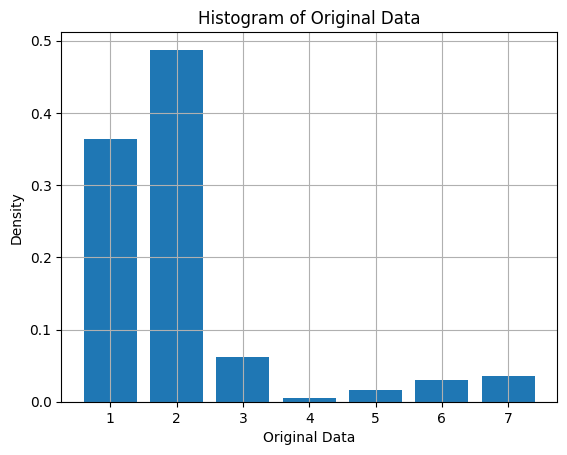

In [3]:
scripts.plot_histogram(y_tree, label='Original Data')

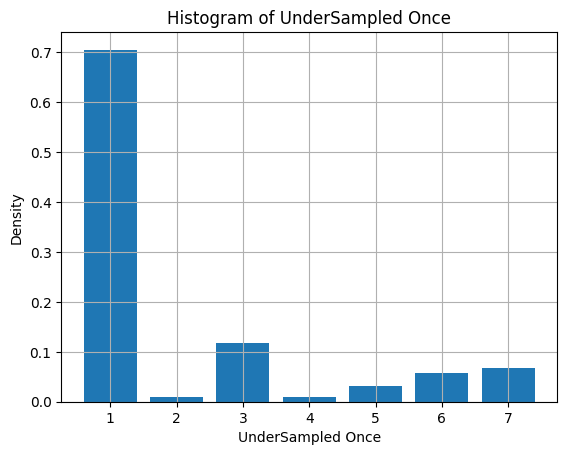

In [4]:
scripts.plot_histogram(pd.Series(y_underSampled), label='UnderSampled Once')

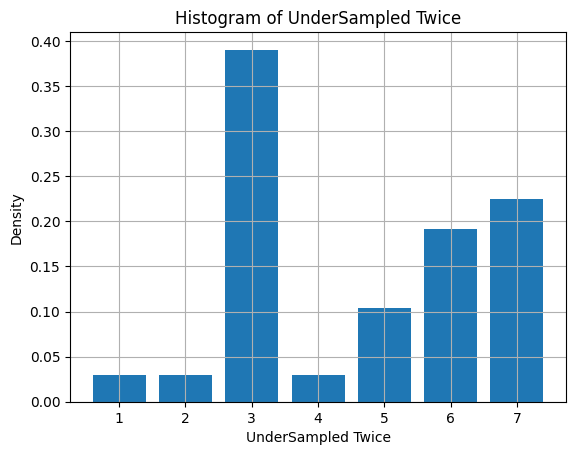

In [5]:
scripts.plot_histogram(pd.Series(y_underSampled2), label='UnderSampled Twice')

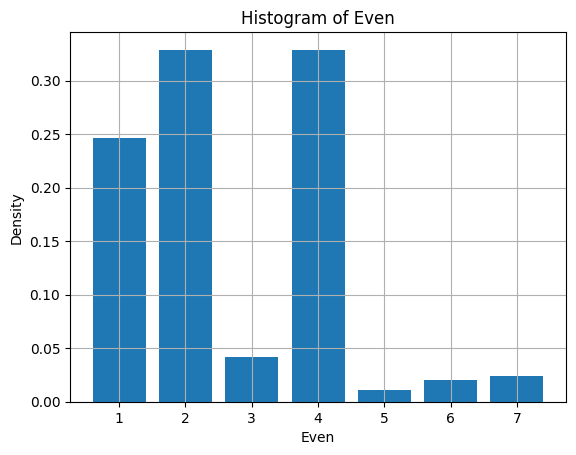

In [6]:
scripts.plot_histogram(pd.Series(y_even), label='Even')

## Scaling Dataset

In [7]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_Scaled_train, x_Scaled_test, y_Scaled_train, y_Scaled_test = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

In [8]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_train[:, :10])

dataScaled = np.concatenate((scaled, x_train[:,10:54]), axis=1)

x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(dataScaled, y_train.reshape(-1, 1), test_size=0.2)

In [9]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled[:,10:54]), axis=1)

x_underSampled_train_scaled, x_underSampled_test_scaled, y_underSampled_train_scaled, y_underSampled_test_scaled = train_test_split(dataScaled, y_underSampled.reshape(-1, 1), test_size=0.2)

In [10]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_underSampled2[:, :10])

dataScaled = np.concatenate((scaled, x_underSampled2[:,10:54]), axis=1)

x_underSampled2_train_scaled, x_underSampled2_test_scaled, y_underSampled2_train_scaled, y_underSampled2_test_scaled = train_test_split(dataScaled, y_underSampled2.reshape(-1, 1), test_size=0.2)

In [11]:
scalar = StandardScaler()

scaled = scalar.fit_transform(x_even[:, :10])

dataScaled = np.concatenate((scaled, x_even[:,10:54]), axis=1)

x_even_train_scaled, x_even_test_scaled, y_even_train_scaled, y_even_test_scaled = train_test_split(dataScaled, y_even.reshape(-1, 1), test_size=0.2)

## GridSearch with balanced class weights

In [16]:
mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)
param_grid_LR = {"penalty": ['l2', 'l1', 'elasticnet'], \
"C": [1.0, 0.75, 0.5, 0.25, 0], "max_iter": [1000, 2000]}

param_grid_SGD = {"penalty": ['l2', 'l1', 'elasticnet'], "max_iter": [1000, 2000]}

model_LRB = LogisticRegression(class_weight='balanced')
model_SGDB = SGDClassifier(class_weight='balanced')
model_LR = LogisticRegression()
model_SGD = SGDClassifier()

## Orginal Data

In [17]:
grid_searchLRB = GridSearchCV(model_LRB, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGDB = GridSearchCV(model_SGDB, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLRB.fit(x_train_scaled, y_train_scaled.ravel())
grid_searchSGDB.fit(x_train_scaled, y_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.447 total time=  12.0s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.447 total time=  12.9s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.446 total time=  12.2s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.438 total time=   6.6s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.438 total time=   7.1s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.433 total time=   6.3s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.411 total time=  10.4s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.416 total time=   7.8s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier...ht='balanced')
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Under Sampled Once

In [18]:
grid_searchLRB_1 = GridSearchCV(model_LRB, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGDB_1 = GridSearchCV(model_SGDB, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLRB_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())
grid_searchSGDB_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.522 total time=   7.7s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.525 total time=   6.5s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.521 total time=   6.1s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.648 total time=   2.9s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.650 total time=   2.9s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.654 total time=   2.6s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.638 total time=   3.9s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.662 total time=   4.2s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier...ht='balanced')
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## UnderSampled Twice

In [19]:
grid_searchLRB_2 = GridSearchCV(model_LRB, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGDB_2 = GridSearchCV(model_SGDB, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLRB_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())
grid_searchSGDB_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.611 total time=   3.0s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.612 total time=   2.9s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.612 total time=   2.3s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.594 total time=   0.4s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.583 total time=   0.4s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.598 total time=   0.3s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.622 total time=   0.8s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.623 total time=   0.8s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier...ht='balanced')
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Even

In [20]:
grid_searchLRB_even = GridSearchCV(model_LRB, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGDB_even = GridSearchCV(model_SGDB, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLRB_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())
grid_searchSGDB_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.611 total time=  14.2s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.610 total time=  17.1s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.611 total time=  18.1s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.686 total time=   4.4s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.677 total time=   5.0s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.672 total time=   4.9s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.678 total time=  11.5s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.668 total time=  13.9s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier...ht='balanced')
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Best Models from Grid Search

In [21]:
print("Original Data: ", grid_searchLRB.best_params_, grid_searchLRB.best_score_)
print("Original Data: ", grid_searchSGDB.best_params_, grid_searchSGDB.best_score_)
print("UnderSampled Once: ", grid_searchLRB_1.best_params_, grid_searchLRB_1.best_score_)
print("UnderSampled Once: ", grid_searchSGDB_1.best_params_, grid_searchSGDB_1.best_score_)
print("UnderSampled Twice: ", grid_searchLRB_2.best_params_, grid_searchLRB_2.best_score_)
print("UnderSampled Twice: ", grid_searchSGDB_2.best_params_, grid_searchSGDB_2.best_score_)
print("Even: ", grid_searchLRB_even.best_params_, grid_searchLRB_even.best_score_)
print("Even: ", grid_searchSGDB_even.best_params_, grid_searchSGDB_even.best_score_)

Original Data:  {'C': 0.75, 'max_iter': 1000, 'penalty': 'l2'} 0.44674065711717015
Original Data:  {'max_iter': 2000, 'penalty': 'l2'} 0.4380766292092865
UnderSampled Once:  {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2'} 0.5228808907392671
UnderSampled Once:  {'max_iter': 1000, 'penalty': 'l1'} 0.6540730686288713
UnderSampled Twice:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'} 0.6118541224595452
UnderSampled Twice:  {'max_iter': 1000, 'penalty': 'elasticnet'} 0.6158005441306257
Even:  {'C': 0.25, 'max_iter': 1000, 'penalty': 'l2'} 0.6110917067352974
Even:  {'max_iter': 2000, 'penalty': 'elasticnet'} 0.6798120848790711


## GridSearch without class weights

## Orginal Data

In [22]:
grid_searchLR = GridSearchCV(model_LR, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGD = GridSearchCV(model_SGD, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLR.fit(x_train_scaled, y_train_scaled.ravel())
grid_searchSGD.fit(x_train_scaled, y_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.550 total time=  10.3s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.551 total time=  10.3s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.549 total time=  10.4s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.532 total time=   3.0s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.530 total time=   2.9s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.532 total time=   3.0s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.529 total time=   4.0s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.529 total time=   3.8s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier()
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Under Sampled Once

In [23]:
grid_searchLR_1 = GridSearchCV(model_LR, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGD_1 = GridSearchCV(model_SGD, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLR_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())
grid_searchSGD_1.fit(x_underSampled_train_scaled, y_underSampled_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.727 total time=   5.2s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.723 total time=   4.0s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.725 total time=   4.5s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.670 total time=   1.5s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.680 total time=   1.4s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.681 total time=   1.4s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.675 total time=   1.9s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.673 total time=   2.0s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier()
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## UnderSampled Twice

In [24]:
grid_searchLR_2 = GridSearchCV(model_LR, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGD_2 = GridSearchCV(model_SGD, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLR_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())
grid_searchSGD_2.fit(x_underSampled2_train_scaled, y_underSampled2_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.695 total time=   2.1s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.702 total time=   2.7s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.693 total time=   2.7s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.657 total time=   0.3s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.661 total time=   0.3s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.655 total time=   0.3s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.657 total time=   0.6s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.657 total time=   0.6s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier()
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Even

In [25]:
grid_searchLR_even = GridSearchCV(model_LR, param_grid_LR, cv=3, scoring=mcc_scorer, verbose=10)
grid_searchSGD_even = GridSearchCV(model_SGD, param_grid_SGD, cv=3, scoring=mcc_scorer, verbose=10)

grid_searchLR_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())
grid_searchSGD_even.fit(x_even_train_scaled, y_even_train_scaled.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 1/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.722 total time=  16.3s
[CV 2/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 2/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.723 total time=  18.5s
[CV 3/3; 1/30] START C=1.0, max_iter=1000, penalty=l2...........................
[CV 3/3; 1/30] END C=1.0, max_iter=1000, penalty=l2;, score=0.725 total time=  17.8s
[CV 1/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 1/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 2/3; 2/30] END C=1.0, max_iter=1000, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 2/30] START C=1.0, max_iter=1000, penalty=l1...........................
[CV 3/3; 2/30] END C=1.0, max_it

/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
66 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seb/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py", line 1218, in fit
    so

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 1/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.698 total time=   3.6s
[CV 2/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 2/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.699 total time=   3.6s
[CV 3/3; 1/6] START max_iter=1000, penalty=l2...................................
[CV 3/3; 1/6] END ....max_iter=1000, penalty=l2;, score=0.704 total time=   3.6s
[CV 1/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 1/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.706 total time=   5.2s
[CV 2/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 2/3; 2/6] END ....max_iter=1000, penalty=l1;, score=0.702 total time=   5.5s
[CV 3/3; 2/6] START max_iter=1000, penalty=l1...................................
[CV 3/3; 2/6] END ....max_iter=1000, penalty=l1;,

,estimator,SGDClassifier()
,param_grid,"{'max_iter': [1000, 2000], 'penalty': ['l2', 'l1', ...]}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,None
,refit,True
,cv,3
,verbose,10
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'hinge'


## Best Models from Grid Search

In [26]:
print("Original Data: ", grid_searchLR.best_params_, grid_searchLR.best_score_)
print("Original Data: ", grid_searchSGD.best_params_, grid_searchSGD.best_score_)
print("UnderSampled Once: ", grid_searchLR_1.best_params_, grid_searchLR_1.best_score_)
print("UnderSampled Once: ", grid_searchSGD_1.best_params_, grid_searchSGD_1.best_score_)
print("UnderSampled Twice: ", grid_searchLR_2.best_params_, grid_searchLR_2.best_score_)
print("UnderSampled Twice: ", grid_searchSGD_2.best_params_, grid_searchSGD_2.best_score_)
print("Even: ", grid_searchLR_even.best_params_, grid_searchLR_even.best_score_)
print("Even: ", grid_searchSGD_even.best_params_, grid_searchSGD_even.best_score_)

Original Data:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'} 0.5501675146301813
Original Data:  {'max_iter': 1000, 'penalty': 'l2'} 0.5312209222912615
UnderSampled Once:  {'C': 0.75, 'max_iter': 1000, 'penalty': 'l2'} 0.7252346401692739
UnderSampled Once:  {'max_iter': 1000, 'penalty': 'elasticnet'} 0.6791202060384242
UnderSampled Twice:  {'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'} 0.6969494003820856
UnderSampled Twice:  {'max_iter': 1000, 'penalty': 'l1'} 0.6586204627573659
Even:  {'C': 0.5, 'max_iter': 1000, 'penalty': 'l2'} 0.7234565647437478
Even:  {'max_iter': 2000, 'penalty': 'l1'} 0.7078286334869048


## Best Model by MCC Score

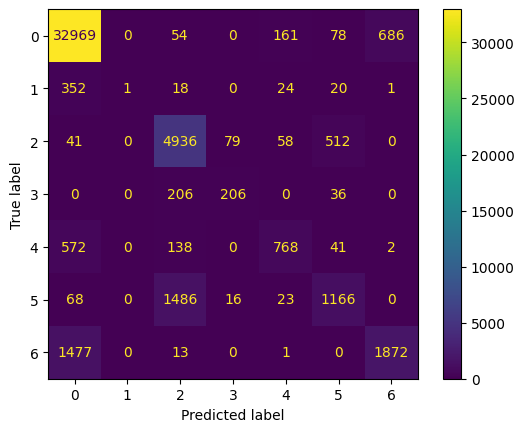

In [16]:
bestCMD = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_underSampled_test_scaled, grid_searchLR_1.best_estimator_.predict(x_underSampled_test_scaled)))
bestCMD.plot()

Prediction of class 1 is not good enough, model can not be considered.

## Best Model

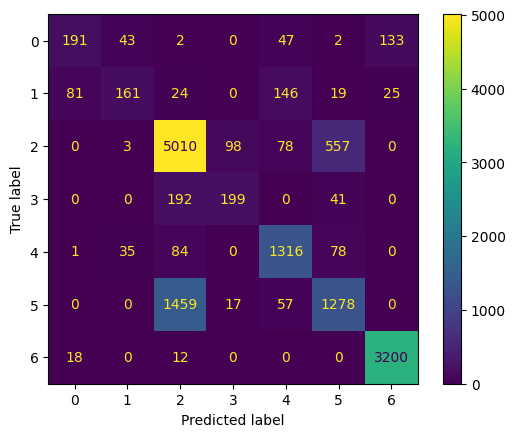

In [17]:
bestCMD = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_underSampled2_test_scaled, grid_searchLR_2.best_estimator_.predict(x_underSampled2_test_scaled)))
bestCMD.plot()

## Shap

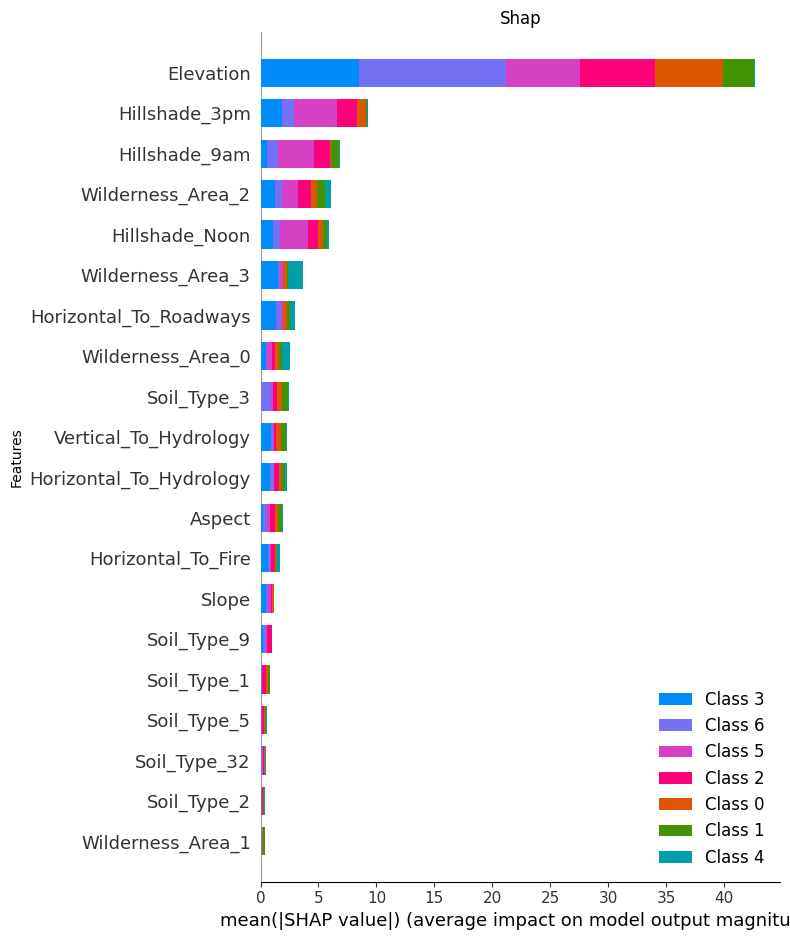

In [19]:
explainer = shap.Explainer(grid_searchLR_2.best_estimator_, x_underSampled2_train_scaled, feature_names=tree_cols)
shap_values = explainer(x_underSampled2_train_scaled)

plt.title("Shap")
plt.xlabel("Shap Value")
plt.ylabel("Features")
shap.summary_plot(shap_values)

## Save Best Model

In [27]:
with open('../data/models/LinearModel.pkl', 'wb') as f:
    pickle.dump(grid_searchLR_2.best_estimator_, f)